# Import packages and load to orignal log of UWV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

def date_parser(s):
    """
    Parse a date string using the log file's format. For example: '2015/10/16 11:25:59.000'
    """
    without_ms = s.split('.')[0]
    return datetime.datetime.strptime(without_ms, '%Y/%m/%d %H:%M:%S')

#log = pd.read_csv('data/log.csv', parse_dates=['startTime', 'completeTime'], date_parser=date_parser)

# Events without an event type are pretty useless so we might as well drop them
#log.dropna(axis=0, subset=['event'], inplace=True)
#log.head()

In [ ]:
log['sessionid'].nunique()

In [ ]:
sad_log_1Q=pd.read_csv('data/sad_log_1Q.csv', encoding= "ISO-8859-1")
happy_log=pd.read_csv('data/happy_log.csv', encoding= "ISO-8859-1")

In [ ]:
sad_log_1Q['asked_question']=1
happy_log['asked_question']=0
log=pd.concat([happy_log, sad_log_1Q], axis=0)
log['sessionid'].nunique()

# Create session summary
## Aggregate log by sessions

In [ ]:
# Make sure the list of activities per session will be ordered by time
log.sort_values(['sessionid', 'startTime'], ascending=[True, True], inplace=True)
log['startTime']=log['completeTime']

# Define aggregations when looking at each session
aggregations = {'event': lambda x: list(x), 
                'case': 'first',
                'startTime': 'first', 
                'completeTime': 'last', 
                'gender': 'first',
                'agecategory': 'first',
                'asked_question': 'first',
               }
sessions = log.groupby('sessionid', as_index=False).agg(aggregations)

In [ ]:
def sessions_customers(sessions, x):
    SS=sessions[sessions['case']==x['case']].sort_values('startTime').reset_index(drop=True)
    total_sessions=len(SS)
    sessions_so_far=SS[SS['sessionid']==x['sessionid']].index[0]
    return total_sessions, sessions_so_far

from tqdm import tqdm
tqdm.pandas(tqdm())
sessions2=sessions.copy()

sessions['total_sessions'], sessions['sessions_so_far'] = zip(*sessions.progress_apply(lambda x: sessions_customers(sessions2, x), axis=1))

## Remove reoccurences of questions

In [ ]:
def eliminate_leakage(event_list, including=True):
    """
    Cut sessions at the point where a question is asked, (including the question itself or not).
    If the trace does not include a question, return it unchanged.
    """
    try:
        question_index = event_list.index('Question')
        if including:
            question_index = question_index + 1
        else:
            question_index = question_index
        return event_list[:question_index]
    except ValueError:
        return event_list
    
#sessions['event'] = sessions['event'].apply(eliminate_leakage)

# Feature Engineering

## Age category, Max loops, hour, gender 

In [ ]:
from collections import Counter

# If there is a question within a session, return a 1, else a 0
def asked_question(event_list):
    return int(event_list[-1] == 'Question')

# Ordinal mapping of age categories
def age(age_cat):
    mapping = {'30-39': 35, '50-65': 57, '40-49': 45, '18-29': 23}
    return mapping[age_cat]

# This function returns:
# 1) The most visisted page within the session
# 2) The times that page is visited
def max_loops(event_list):
    num_events=len(event_list)
    event_counter = Counter(event_list)
    most_visited_page = max(event_counter, key=event_counter.get)
    times_visited = event_counter[most_visited_page]
    if times_visited == 1:
        most_visited_page = None
        
    inds=[index for index, value in enumerate(event_list) if value==most_visited_page]
    if len(inds)==0:
        avg_steps=0
    else:
        steps=np.diff(inds)
        avg_steps=np.mean(steps)+1
    return most_visited_page, times_visited, avg_steps, num_events

# The hour of the timestamp can be seen as a feature
def hour(timestamp):
    return timestamp.hour

# Gender of a customer
def gender(gender):
    """
    This could be done directly on the DF but lets keep the same style for everything
    """
    return int(gender == 'M')

    
# Create target variable - Did this session end up with a question?
#sessions['asked_question'] = sessions['event'].apply(asked_question)
#sessions['event'] = sessions['event'].apply(eliminate_leakage,including=False)

# Gender from character to int
sessions['gender'] = sessions['gender'].apply(gender)

# Age from category to int and rename column
sessions['agecategory'] = sessions['agecategory'].apply(age)
sessions.rename(columns={'agecategory': 'age'}, inplace=True)

# Hour of day when the session took place.
sessions['startTime']=sessions['startTime'].apply(pd.to_datetime)
sessions['completeTime']=sessions['completeTime'].apply(pd.to_datetime)
sessions['hour'] = sessions['startTime'].apply(hour)

timediff=sessions['completeTime']-sessions['startTime']
sessions['timediff'] = timediff.apply(lambda x: x.seconds)

# Max number of page reoccurence within the sessions and the page mostly visited. 
# If each page was visited once then mostly visited will be None. The start syntax is interesting,
# it allows the apply function to create multiple outputs. This could be useful for the TODO step
# mentioned below.
sessions['most_visited_page'], sessions['max_loops'], sessions['avg_steps'], sessions['num_events'] = zip(*sessions['event'].apply(max_loops))

############################################# TODO ########################################################
### We could use the 'most_visited' column to create smart dummy variables. For example something like: ### 
### Is the home page the mostly visited, or the same for other interesting pages.                       ###
############################################# TODO ########################################################

## Presence of trigger events by Markov Chain model 

In [13]:
trigger_events= ['Visit page mijn_werkmap','Visit page home','Visit page taken',
                 'Visit page vacatures_bij_mijn_cv','Visit page mijn_berichten',
                 'Visit page werkmap','Visit page mijn_documenten',
                 'Visit page mijn_sollicitaties','Visit page mijn_cv',
                 'Visit page mijn_tips','Visit page inschrijven',
                 'Visit page foutopgetreden.html']

In [ ]:
for event in trigger_events:
    sessions[event]=sessions['event'].apply(lambda x: int(event in x))

# Machine Learning to predict questions

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
sessions=pd.read_csv('data/sessions_1Q.csv')


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

y = sessions['asked_question']
# Include more columns in the future!
X = sessions.drop(['asked_question', 'sessionid', 'startTime', 'completeTime', 'most_visited_page', 'event', 'case', 'total_sessions', 'predictions', 'predictions_prob'], axis=1)

#X = sessions[trigger_events]

features=X.columns
#classes=y.columns
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest

In [57]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 'class_weight':[{1: w} for w in [1, 2, 3, 4, 5, 6, 10]]}
#param_grid = {'C':[1,10]}

clf=RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, cv=3,scoring='roc_auc',n_jobs=3, verbose=3)
model=grid.fit(X_train, y_train)
    
best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
print('Normalized AUC:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   20.7s
[Parallel(n_jobs=3)]: Done 147 out of 147 | elapsed:   23.6s finished


Normalized AUC: 0.654725531912
class_weight: {1: 2}
max_depth: 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [58]:
model = RandomForestClassifier(max_depth=best_parameters['max_depth'], class_weight= best_parameters['class_weight'], random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 2}, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

## Decision Tree

In [22]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': [2, 3, 4], 'class_weight':[{1: w} for w in range(1,20)]}
grid = GridSearchCV(clf, param_grid, cv=3,scoring='roc_auc',n_jobs=3, verbose=3)
model=grid.fit(X_train, y_train)
    
best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
print('Normalized AUC:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


Fitting 3 folds for each of 57 candidates, totalling 171 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   12.8s
[Parallel(n_jobs=3)]: Done 171 out of 171 | elapsed:   15.2s finished


Normalized AUC: 0.640324156398
class_weight: {1: 11}
max_depth: 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [23]:
model = tree.DecisionTreeClassifier(max_depth=best_parameters['max_depth'], class_weight= best_parameters['class_weight'], random_state=42)
model = model.fit(X_train, np.array(y_train)) 

import graphviz
dot_data = tree.export_graphviz(model, out_file=None, )
graph = graphviz.Source(dot_data) 
graph.render("Page Visits") 

'Page Visits.pdf'

In [ ]:
dot_data = tree.export_graphviz(model, out_file=None, feature_names=features, class_names=['nQ', 'Q'],filled=True, rounded=True,special_characters=True, impurity=False, rotate=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

## xgboost Model (Santiago)



In [ ]:
import xgboost as xgb

#tuning_params = {'max_depth': [3,4,5,6,7,8], 'min_child_weight':range(1,6,2), 'gamma':[i/10.0 for i in range(0,5)],'subsample':[i/10.0 for i in range(6,10)],
# 'colsample_bytree':[i/10.0 for i in range(6,10)],  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}

tuning_params = {'max_depth': [3,4,5,6,7,8]}

grid = GridSearchCV(xgb.XGBClassifier(objective= 'binary:logistic'), tuning_params, cv=3,scoring='roc_auc',n_jobs=3)
model = grid.fit(X_train, y_train)

best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
print('Normalized AUC:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

    
model = xgb.XGBClassifier(max_depth=best_parameters[param_name])
model.fit(X_train, y_train)



## Optimal Threshold

In [18]:
def optimal_threshold(fpr, tpr, thresholds):
    """
    This funtion select the threshold where the sum of sensitivity and specificity are maximum.

    This creiteria is based on:
    Bayesian regression methodology for estimating a receiver operating characteristic curve with two radiologic applications: 
    prostate biopsy and spiral CT of ureteral stones.
    
    #Parameters:
    - From the ROC 
    a) fpr: false positive rate
    b) tpr: true positive rate
    c) thresholds: thresholds
    
    """
    sensitivity = tpr
    specificity = 1 - fpr
    opt_threshold = np.argmax(sensitivity + specificity)
    opt_fpr = fpr[opt_threshold]
    opt_trp = tpr[opt_threshold]
    
    
    return thresholds[opt_threshold], opt_fpr, opt_trp


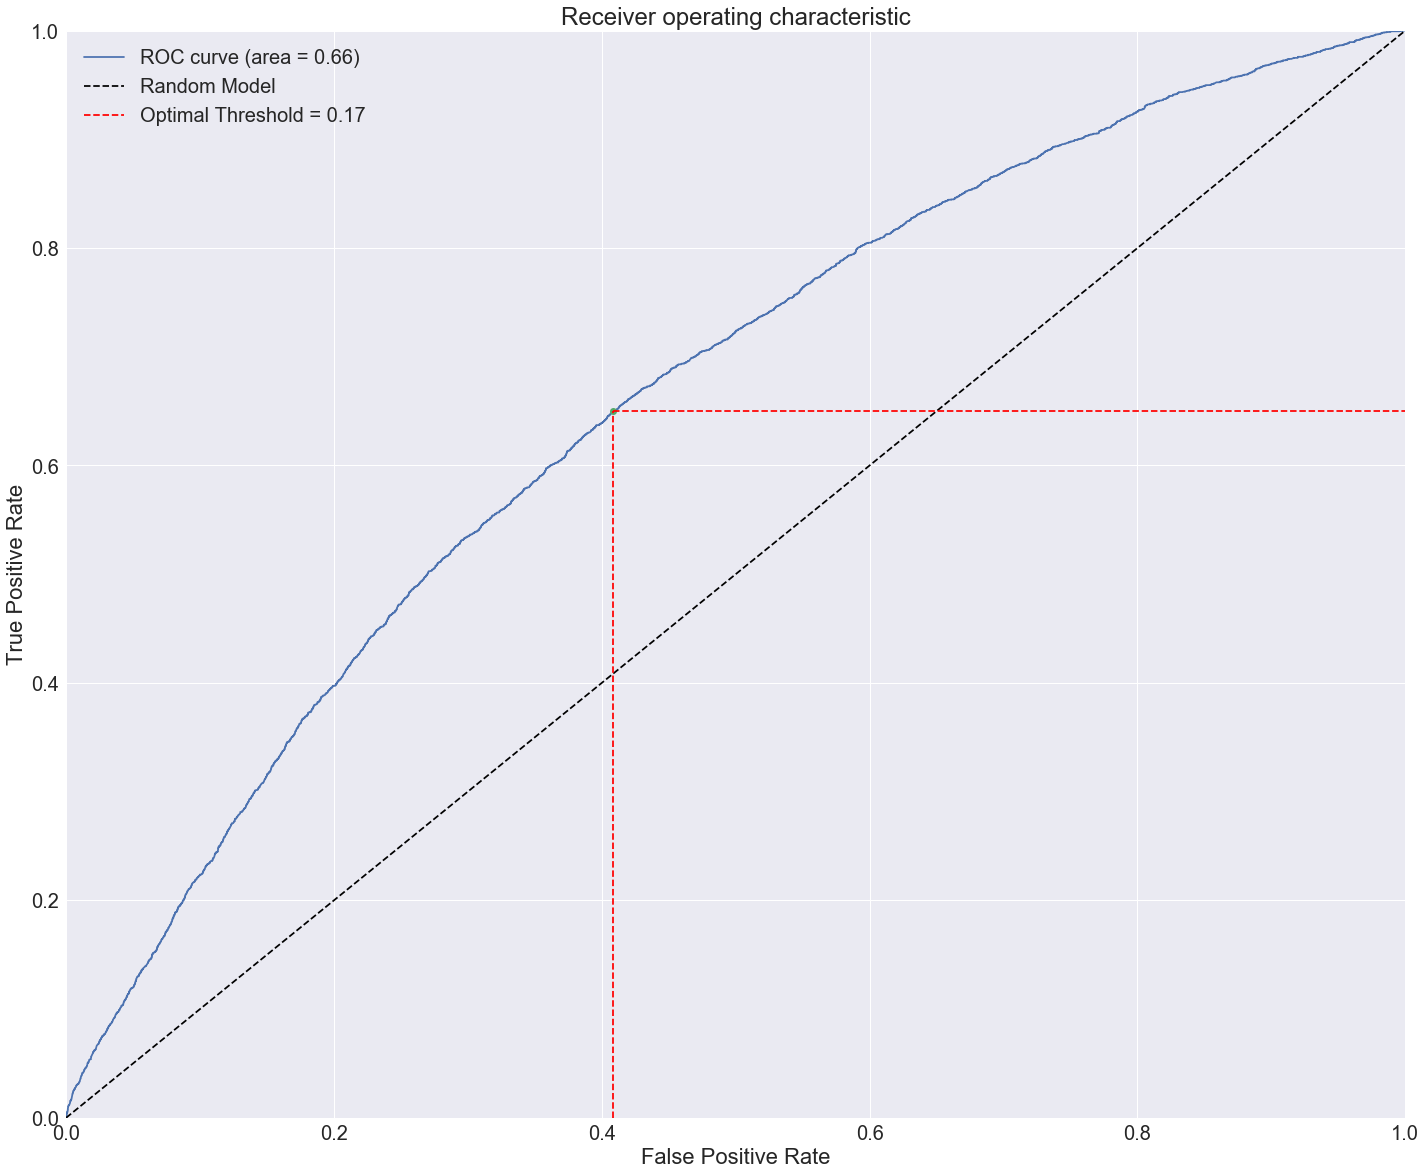

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import seaborn
#Taken from: http://abhay.harpale.net/blog/machine-learning/threshold-tuning-using-roc/



#Predit the prob
predictions_prob = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)


sns.set(font_scale=2)
plt.figure(figsize=(24, 20))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--',label = 'Random Model')
#plt.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r', label = 'Threshold')
plt.plot(opt_fpr, opt_trp, 'o',linewidth=3)
plt.axvline(x = opt_fpr, ymax = opt_trp, linestyle='dashed', color='r'  )
plt.axhline(y = opt_trp, xmin =opt_fpr , linestyle='dashed', color='r' ,label = 'Optimal Threshold = %0.2f' % (opt_threshold) )


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='upper left')

#plt.savefig('roc_and_threshold.png')
plt.show()
plt.close()



In [60]:
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)
predictions= predictions_prob.copy()
predictions[predictions<opt_threshold] = 0
predictions[predictions>=opt_threshold] = 1
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[18892 13050]
 [ 1088  2023]]
0.59666790289


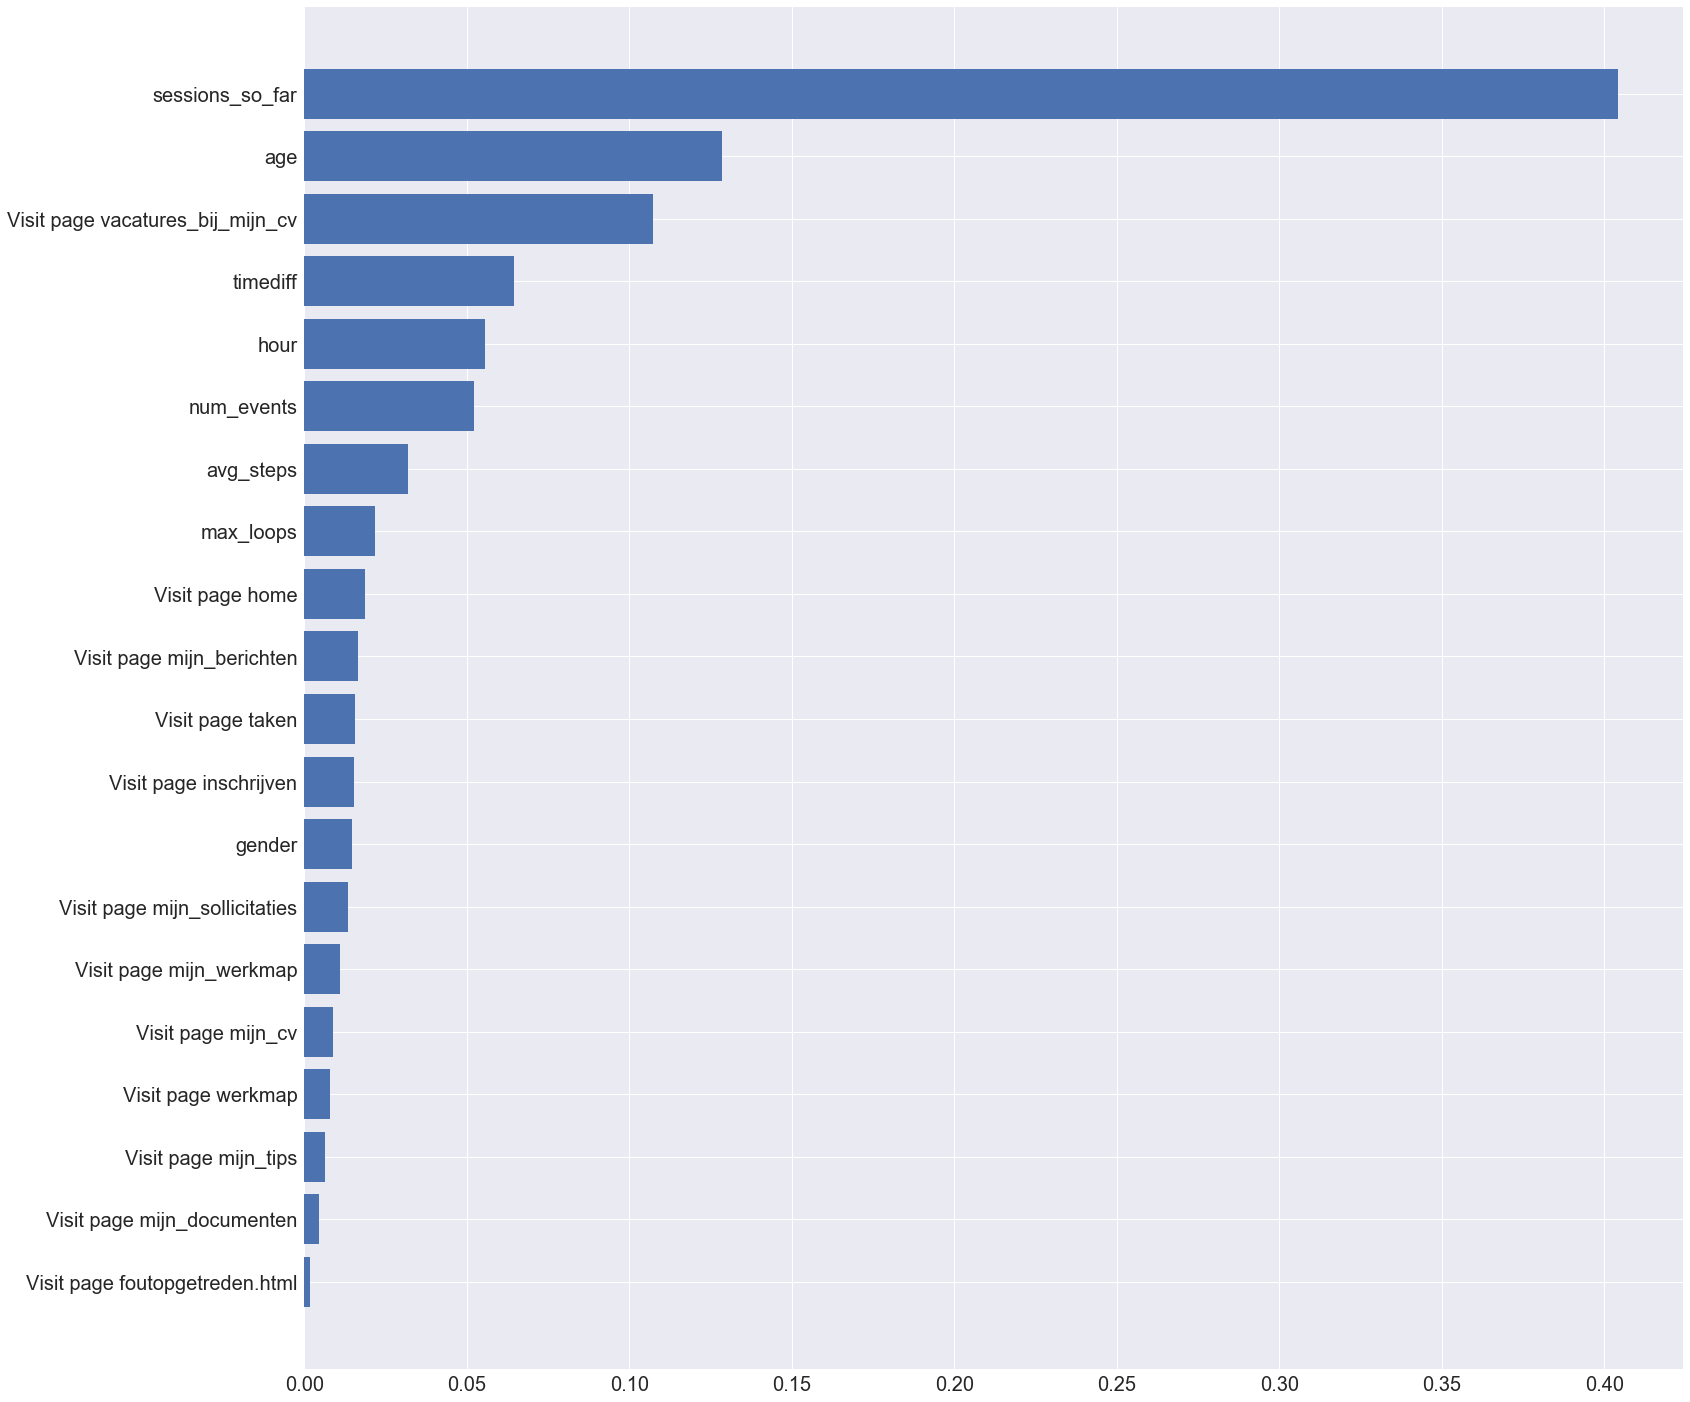

In [61]:
import matplotlib.pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    sns.set(font_scale=2)
    plt.figure(figsize=(24, 20))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.tight_layout()
    plt.savefig('Important features')
    plt.show()

    
f_importances(model.feature_importances_, features)

# Descriptive statistics

In [ ]:
sessions.T

In [ ]:
%matplotlib inline
sns.countplot('asked_question', data=sessions, hue='Visit page vacatures_bij_mijn_cv')

In [ ]:
sns.countplot('asked_question', data=sessions)

In [ ]:
sns.countplot('Visit page vacatures_bij_mijn_cv', data=sessions)

In [ ]:
def subsetsession(sessions, asked_question=True, mijn_cv=True):
    subset=len(sessions[(sessions['asked_question']==asked_question)&(sessions['Visit page vacatures_bij_mijn_cv']==mijn_cv)])
    prop=subset/len(sessions[(sessions['asked_question']==asked_question)])
    return prop

In [ ]:
subsetsession(sessions)

In [ ]:
subsetsession(sessions, asked_question=False)

In [ ]:
df=pd.DataFrame({'asked_question':[0,1],})

In [ ]:
sns.countplot('age', data=sessions, hue='asked_question')

In [ ]:
df=pd.DataFrame({'age':})

# Predictions/Predictions_prob

In [ ]:
predictions_prob_compl = model.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(y, predictions_prob_compl)
roc_auc = auc(fpr, tpr)
opt_threshold, opt_fpr, opt_trp = optimal_threshold(fpr, tpr, thresholds)

predictions_compl= predictions_prob_compl.copy()
predictions_compl[predictions_compl<opt_threshold] = 0
predictions_compl[predictions_compl>=opt_threshold] = 1

